In [1]:
import pandas as pd
import os
import missingno as msno
import numpy as np

pd.set_option('display.max_rows', 500)

## Improvements or Ideas

1. What is the best way to do predictions on time series data?

## Data Overview

The trip data was downloaded from the [New York City Taxi & Limousine Commission](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page). The following is the data description from TLC's data page:

For-Hire Vehicle (“FHV”) trip records include fields capturing the dispatching base license number and the pick-up date, time, and taxi zone location ID (shape file below). These records are generated from the FHV Trip Record submissions made by bases. Note: The TLC publishes base trip record data as submitted by the bases, and we cannot guarantee or confirm their accuracy or completeness. Therefore, this may not represent the total amount of trips dispatched by all TLC-licensed bases. The TLC performs routine reviews of the records and takes enforcement actions when necessary to ensure, to the extent possible, complete and accurate information.

The weather data, which contains hourly weather readings in New York City, was downloaded from [Kaggle](https://www.kaggle.com/datasets/meinertsen/new-york-city-taxi-trip-hourly-weather-data). The uploader scraped the data from Wunderground.

## Data Assumptions

1. Each row represents a completed trip
2. The FHV data, even though it's not strictly Uber/Lyft/other ride-hailing apps only, is representative of these ride-hailing apps
3. 

## Data Preprocessing

Since the weather data is at the hour-level, the trip data will be aggregated on the same level of granularity. There are 12 tables of weather data, one table for each month of 2016. Each table will be aggregated at the hour level first before combining them together. The aggregation method will be the count of number of rows, which signifies the number of trips at each hour. This count will be the outcome variable--demand.

In [2]:
# loop over the 12 trip data table (1 per month)
# aggregate each table by hour-level, count number of rows (each row is a trip)
# combine the aggregated tables

def agg_hourly(df):
    df = df.resample('60min', on='pickup_datetime').agg({'dropOff_datetime':'size'}).reset_index()
    df = df.rename(columns={'pickup_datetime':'datetime','dropOff_datetime':'trip_count'})
    return df

directory = os.fsencode('../data/trip-data-tlc/raw/')

combined_tripdata = pd.DataFrame([])

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    trip_data = pd.read_parquet('../data/trip-data-tlc/raw/'+filename)
    agg_tripdata = agg_hourly(trip_data)
    combined_tripdata = pd.concat([combined_tripdata,agg_tripdata])

# combined_tripdata.to_csv('../data/trip-data-tlc/aggregated/combined_tripdata.csv')
# combined_tripdata = pd.read_csv('../data/trip-data-tlc/aggregated/combined_tripdata.csv',index_col=0)

display(combined_tripdata.head())
print(combined_tripdata.shape)

,datetime,trip_count
0,2016-01-01 00:00:00,19631
1,2016-01-01 01:00:00,23665
2,2016-01-01 02:00:00,23476
3,2016-01-01 03:00:00,20836
4,2016-01-01 04:00:00,15085


(8784, 2)


The weather data is from 1/1/2016 to 12/31/2016 with a 1-hour interval, with a few records for 12/31/2015 that will be removed. This data records weather values at the 51st minute (i.e., the datetime readings are 12:51 AM, 1:51 AM, 2:51 AM, and so on), but there are cases with multiple readings in a 1-hour interval. These "in-between" readings will be removed for consistency, then the datetime will be resampled so it follows the datetime intervals of the trip data. 

In [3]:
# remove 2015 rows
# remove rows where minute in datetime is not 51

weather_data = pd.read_csv('../data/weather-data/Weather.csv')

def clean_df(df):
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
    df = df[(df['pickup_datetime'].dt.year == 2016)&(df['pickup_datetime'].dt.minute == 51)]
    return df

# resample datetime and take the first value of all columns

weather_data = clean_df(weather_data)
weather_data = weather_data.resample('60min', on='pickup_datetime').first().reset_index()
weather_data = weather_data.rename(columns={'pickup_datetime':'datetime'})
display(weather_data.head())
print(weather_data.shape)

,datetime,tempm,tempi,dewptm,dewpti,hum,wspdm,wspdi,wgustm,wgusti,...,precipm,precipi,conds,icon,fog,rain,snow,hail,thunder,tornado
0,2016-01-01 00:00:00,5.6,42.1,-3.9,25.0,51.0,7.4,4.6,NaN,NaN,...,NaN,NaN,Overcast,cloudy,0.0,0.0,0.0,0.0,0.0,0.0
1,2016-01-01 01:00:00,5.0,41.0,-3.9,25.0,53.0,5.6,3.5,NaN,NaN,...,NaN,NaN,Overcast,cloudy,0.0,0.0,0.0,0.0,0.0,0.0
2,2016-01-01 02:00:00,5.0,41.0,-3.3,26.1,55.0,7.4,4.6,NaN,NaN,...,NaN,NaN,Overcast,cloudy,0.0,0.0,0.0,0.0,0.0,0.0
3,2016-01-01 03:00:00,5.0,41.0,-3.3,26.1,55.0,14.8,9.2,NaN,NaN,...,NaN,NaN,Overcast,cloudy,0.0,0.0,0.0,0.0,0.0,0.0
4,2016-01-01 04:00:00,4.4,39.9,-3.3,26.1,58.0,16.7,10.4,25.9,16.1,...,NaN,NaN,Overcast,cloudy,0.0,0.0,0.0,0.0,0.0,0.0


(8784, 30)


## Feature Engineering

The weather data has readings both in the imperial and metric unit, but only the metric columns will be used. More information on weather variables is available in the Kaggle [page.](https://www.kaggle.com/datasets/meinertsen/new-york-city-taxi-trip-hourly-weather-data)

In [20]:
weather_data = weather_data[['datetime','tempm','dewptm','hum','wspdm',\
                            'wgustm','wdird','wdire','vism','pressurem',\
                            'windchillm','heatindexm','precipm','conds','icon',\
                            'fog','rain','snow','hail','thunder','tornado']]
working_df = combined_tripdata.merge(weather_data, on='datetime')

The following features, which are based on the date-time, will also be added
- hour of the day
- weekend or weekday (boolean)
- day of the week
- month of the year

In [21]:
working_df['hr'] = working_df['datetime'].dt.hour
working_df['day_of_wk'] = working_df['datetime'].apply(lambda x: x.weekday())
working_df['weekend'] = working_df['day_of_wk'].apply(lambda x: 1 if x >= 5 else 0)
working_df['month'] = working_df['datetime'].dt.month

## Data Preprocessing Continued

### Handling Missing Data

To get a gauge of the completeness of the data, the number of non-null values and the corresponding percentage of missing values are displayed for each feature. The data source did not state possible reasons for missing data, so we will assume that observations are not recorded due to reasons including technical and human error, and that the missingness is completely at random. 

In [22]:
completeness = pd.DataFrame(working_df.count()).rename(columns={0:'count'})
completeness['percentage_missing'] = (len(working_df) - completeness['count']) / len(working_df) * 100
completeness.sort_values(by='percentage_missing', ascending=False).head(10)

,count,percentage_missing
precipm,770,91.234062
heatindexm,815,90.721767
wgustm,1499,82.934882
windchillm,2264,74.225865
wspdm,8047,8.390255
vism,8476,3.506375
pressurem,8480,3.460838
hum,8600,2.094718
icon,8600,2.094718
thunder,8600,2.094718


To visualize the missing values:

<Axes: >

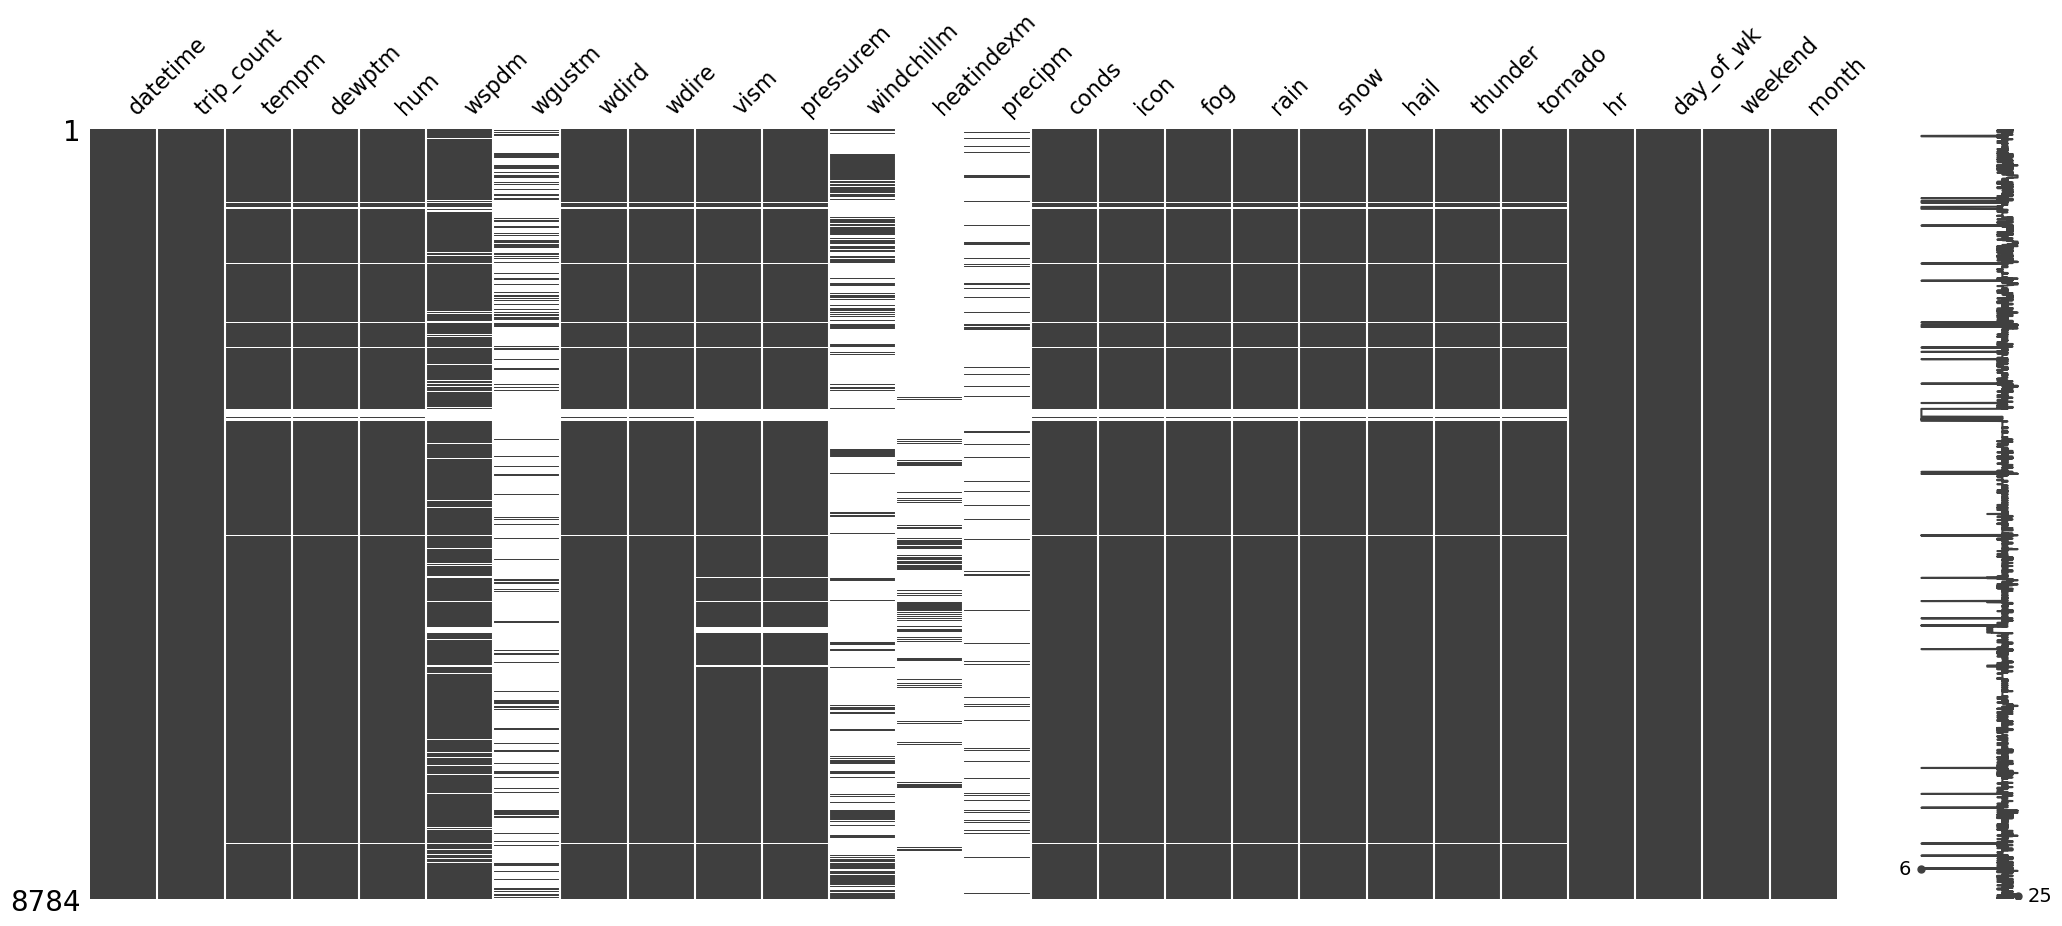

In [23]:
msno.matrix(working_df)

Four features have a lot of missing values, making it difficult to do imputation or dropping of rows, so these columns will be  removed from the analysis. But the other columns with missing values only have at most 8% missing values. Let's see what we can do with these columns.

In [29]:
# columns to be removed from the dataset
remove_cols = ['precipm','heatindexm','wgustm','windchillm']
working_df = working_df.drop(columns=remove_cols)

The missingness of some of the features occur on the same datetimes, as seen on the plot above. And it appears that there are a few consecutive days with missing values for all these features as shown on the thick white horizontal line. We can try to impute or fill the missing values. However, some of these features are categorical variables, making the imputation process not straightforward. We will drop the rows with missing data for these categorical variables, and see what we are left with. 

In [27]:
print(f"Count before: {working_df.shape}")
categorical_cols = ['wdire','conds','icon','fog','rain','snow','hail','thunder','tornado']
working_df = working_df.dropna(subset=categorical_cols, how='any')
print(f"Count after: {working_df.shape}")

completeness = pd.DataFrame(working_df.count()).rename(columns={0:'count'})
completeness['percentage_missing'] = (len(working_df) - completeness['count']) / len(working_df) * 100
completeness.sort_values(by='percentage_missing', ascending=False).head(10)

Count before: (8600, 26)
Count after: (8600, 26)


,count,percentage_missing
precipm,770,91.046512
heatindexm,815,90.523256
wgustm,1499,82.569767
windchillm,2264,73.674419
wspdm,8047,6.430233
vism,8476,1.441860
pressurem,8480,1.395349
fog,8600,0.000000
weekend,8600,0.000000
day_of_wk,8600,0.000000


<Axes: >

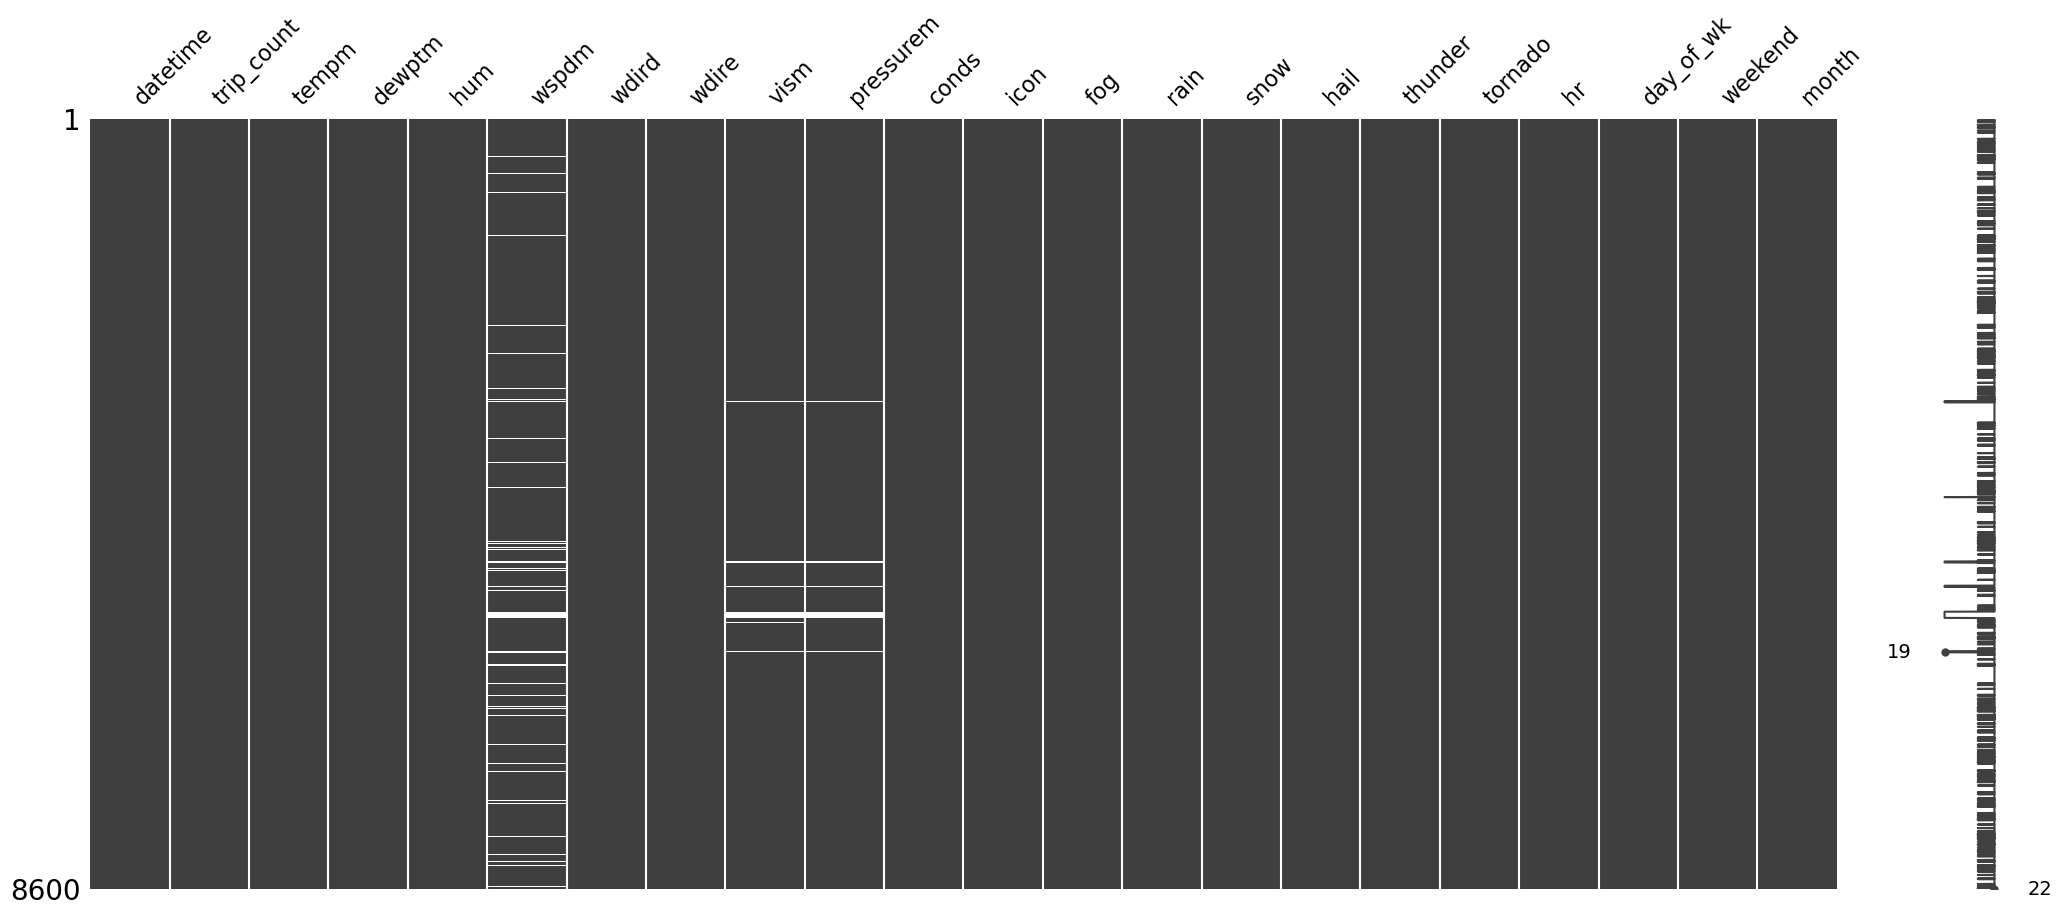

In [30]:
msno.matrix(working_df)

We are now left with 3 weather variables with missing values. But we can also try to impute or fill the missing values with the average of the value before and after. For example, if we have this dataframe with missing values:

In [31]:
sample = pd.DataFrame({'value': [3,4,5,np.nan,4,7,np.nan,5,3]})
sample

,value
0,3.0
1,4.0
2,5.0
3,NaN
4,4.0
5,7.0
6,NaN
7,5.0
8,3.0


We can use the following code to fill the missing values with the average of the values before and after:

In [32]:
sample['value'] = sample['value'].fillna((sample['value'].shift()+sample['value'].shift(-1))/2)
sample

,value
0,3.0
1,4.0
2,5.0
3,4.5
4,4.0
5,7.0
6,6.0
7,5.0
8,3.0


The thing to note here is that we will only impute the missing value if there are values immediately before and after. So the assumption we are making is that the weather variable does not vary a lot within a span of 3 hours. 

In [33]:
cols_to_impute = ['wspdm','vism', 'pressurem']
for col in cols_to_impute:
    working_df[col] = working_df[col].fillna((working_df[col].shift()+working_df[col].shift(-1))/2)
    
completeness = pd.DataFrame(working_df.count()).rename(columns={0:'count'})
completeness['percentage_missing'] = (len(working_df) - completeness['count']) / len(working_df) * 100
completeness.sort_values(by='percentage_missing', ascending=False).head(10)

,count,percentage_missing
wspdm,8404,2.279070
vism,8478,1.418605
pressurem,8482,1.372093
datetime,8600,0.000000
rain,8600,0.000000
weekend,8600,0.000000
day_of_wk,8600,0.000000
hr,8600,0.000000
tornado,8600,0.000000
thunder,8600,0.000000


We were able to fill some of the missing values, but there's still about 2% of the remaining rows with missing values. Since this is relatively small, we decide to drop these rows instead of doing more imputation. 

In [35]:
print(f"Count before: {working_df.shape}")
working_df = working_df.dropna(subset=cols_to_impute, how='any')
print(f"Count after: {working_df.shape}")

completeness = pd.DataFrame(working_df.count()).rename(columns={0:'count'})
completeness['percentage_missing'] = (len(working_df) - completeness['count']) / len(working_df) * 100
completeness.sort_values(by='percentage_missing', ascending=False).head(10)

Count before: (8600, 22)
Count after: (8400, 22)


,count,percentage_missing
datetime,8400,0.0
trip_count,8400,0.0
weekend,8400,0.0
day_of_wk,8400,0.0
hr,8400,0.0
tornado,8400,0.0
thunder,8400,0.0
hail,8400,0.0
snow,8400,0.0
rain,8400,0.0


Our final table has 8400 rows of trip and weather data.